C:\Users\AUC\AppData\Local\Temp\ipykernel_3304\2656282503.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Greens")  # Color map for free cells


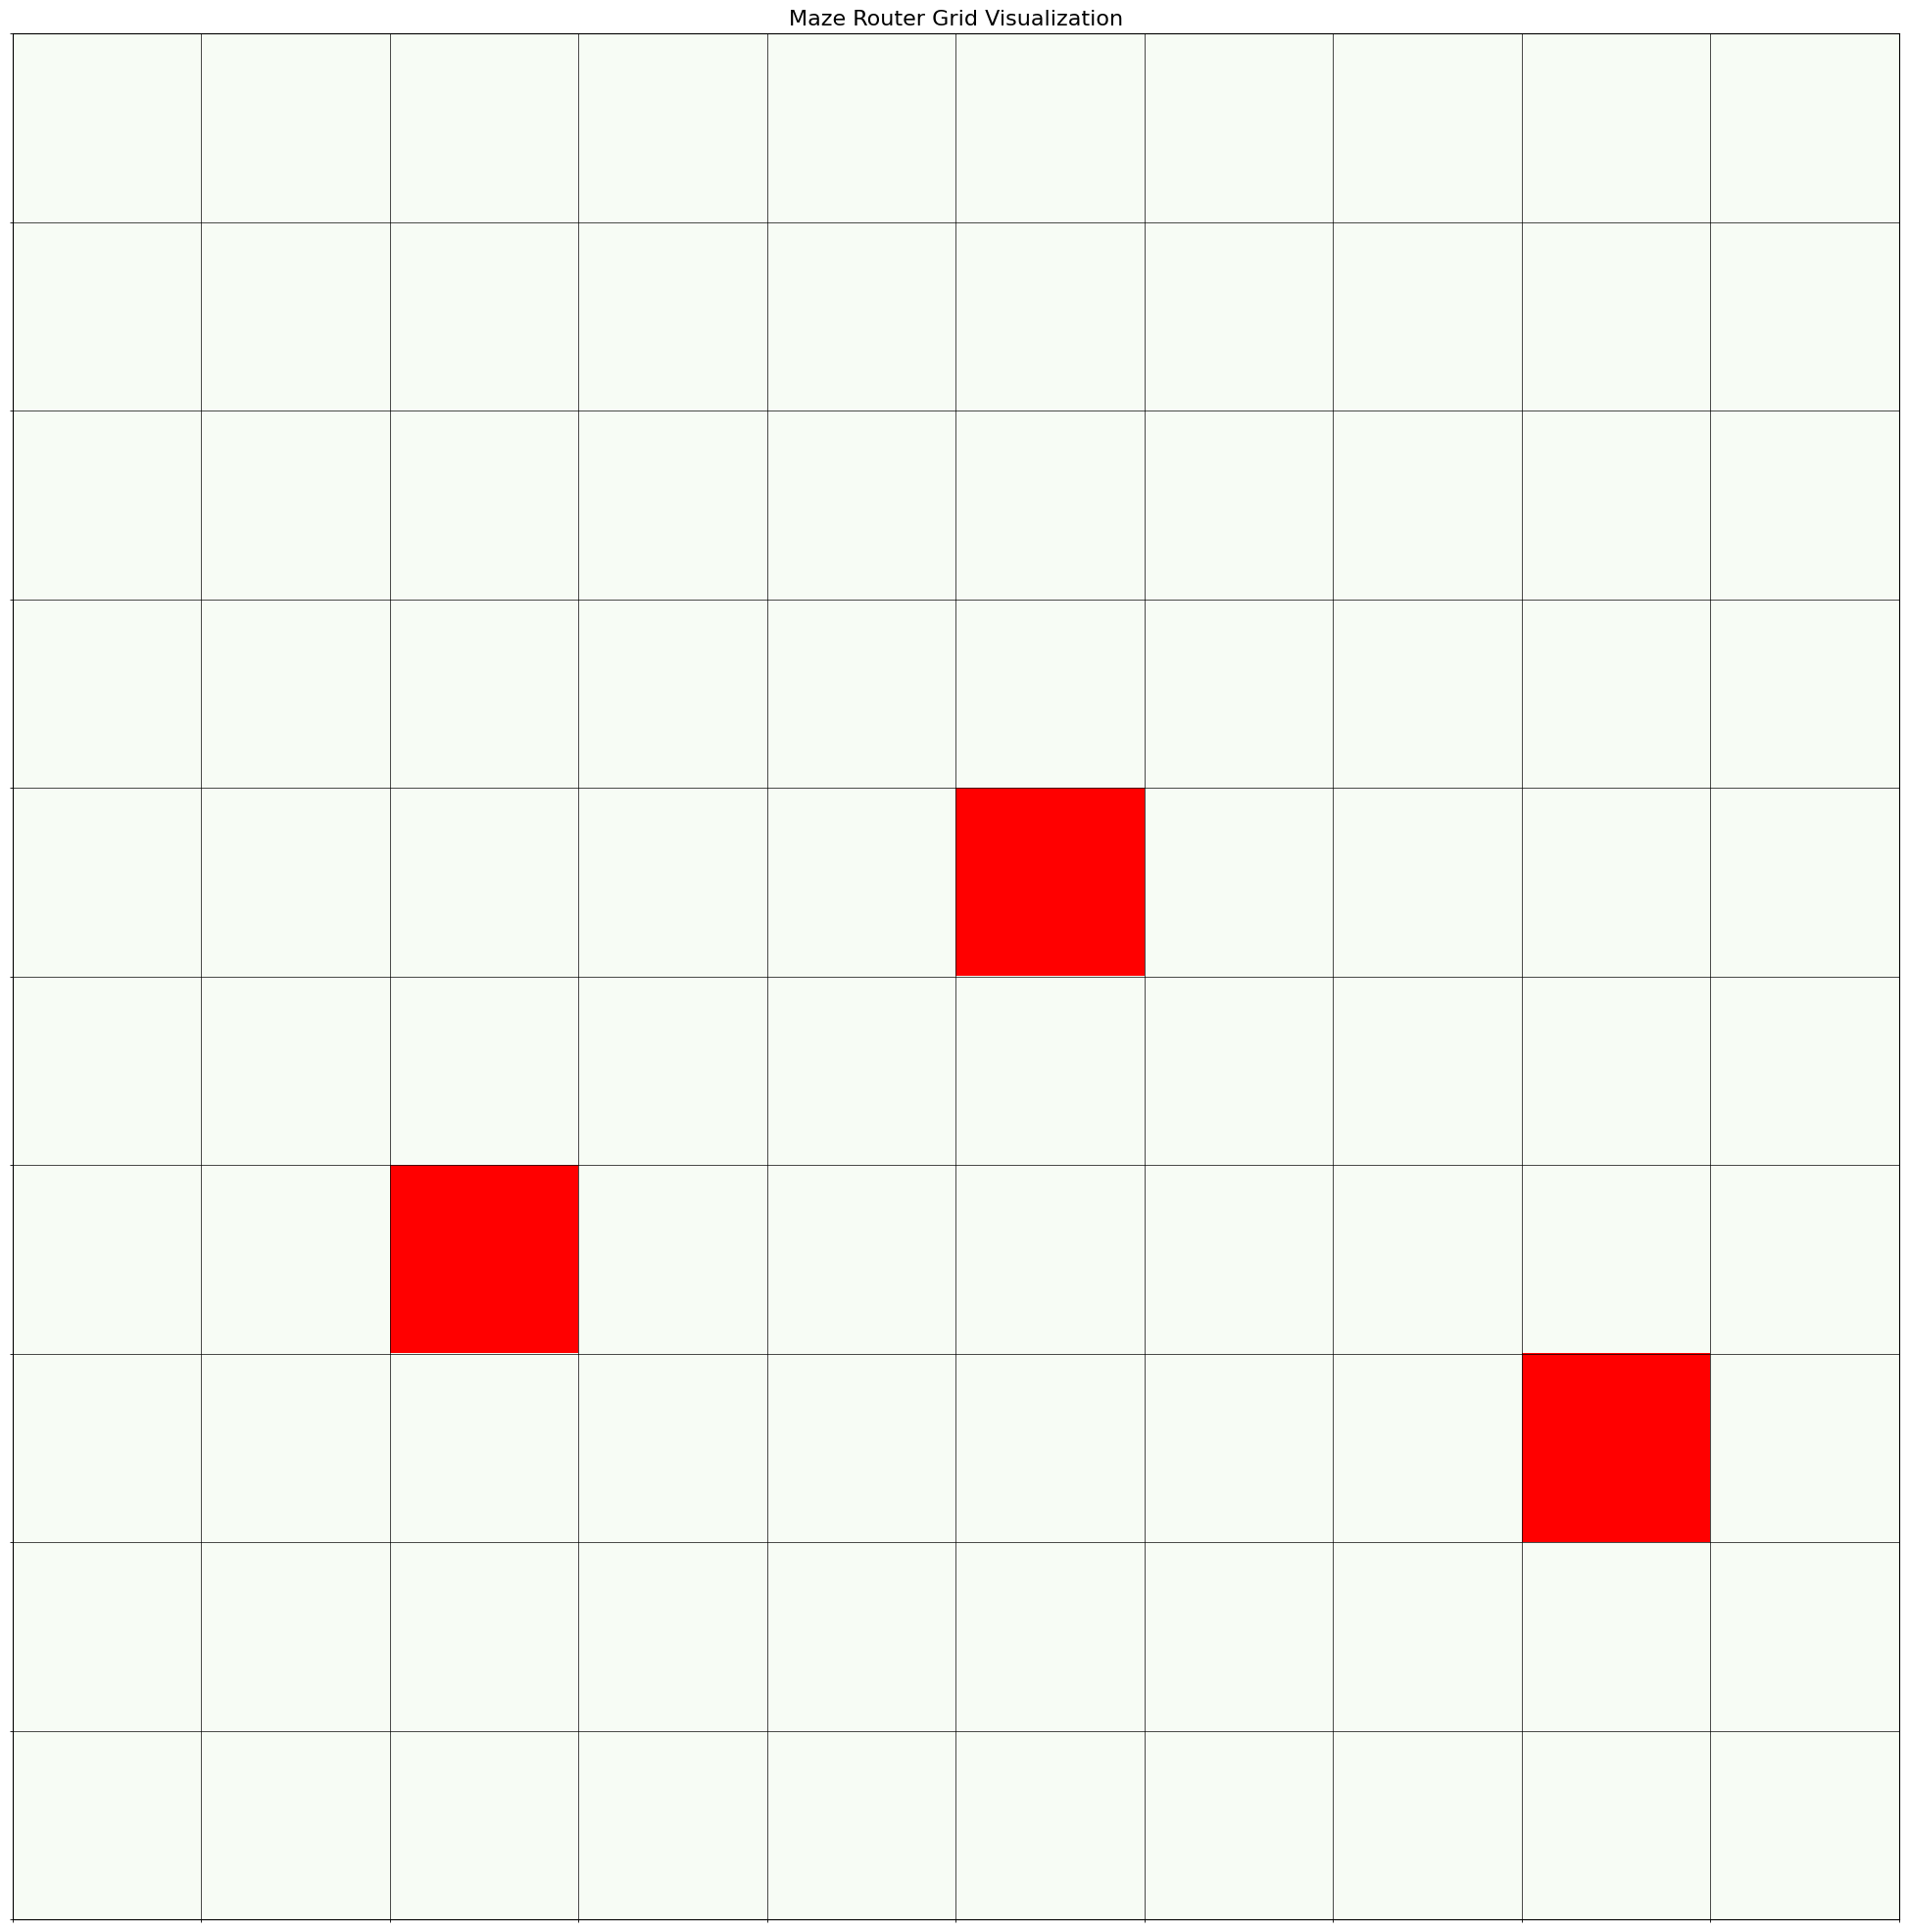

In [ ]:
import re
import matplotlib.pyplot as plt
import numpy as np
# Global variables
grid_dimensions = None
bend_penalty = None
via_penalty = None
obstructions = []
nets = {}
grid = []


# Function to parse the input file
def parse_input_file(file_path):
    global grid_dimensions, bend_penalty, via_penalty, obstructions, nets

    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Parse the grid dimensions and penalties
    grid_info = list(map(int, lines[0].strip().split(',')))
    grid_dimensions = (grid_info[0], grid_info[1])  # NxM grid
    bend_penalty = grid_info[2]
    via_penalty = grid_info[3]

    # Parse the obstructions
    for line in lines[1:]:
        if line.startswith("OBS"):
            match = re.search(r"\((\d+),\s*(\d+),\s*(\d+)\)", line)
            if match:
                obstructions.append((int(match.group(1)), int(match.group(2)), int(match.group(3))))
    
    # Parse the nets
    for line in lines[1:]:
        if line.startswith("net"):
            net_name = line.split(' ')[0]
            net_points = re.findall(r"\((\d+),\s*(\d+),\s*(\d+)\)", line)
            nets[net_name] = [(int(layer), int(x), int(y)) for layer, x, y in net_points]

# Global grid representation

# Function to initialize the grid
def initialize_grid():
    global grid, grid_dimensions, obstructions

    # Extract dimensions
    rows, cols = grid_dimensions

    # Create a 2D list initialized with default cost (0 for simplicity)
    grid = [[{'cost': 0, 'obstruction': False} for _ in range(cols)] for _ in range(rows)]

    # Mark obstructions
    for layer, x, y in obstructions:
        # Use layer-1 indexing to represent each layer separately
        grid[x][y]['obstruction'] = True
        grid[x][y]['cost'] = float('inf')  # Assign a high cost to obstructions


def visualize_grid_matplotlib():
    global grid, grid_dimensions

    # Extract grid dimensions
    rows, cols = grid_dimensions

    # Create a numerical representation of the grid
    grid_matrix = np.zeros((rows, cols), dtype=int)
    for row in range(rows):
        for col in range(cols):
            if grid[row][col]['obstruction']:
                grid_matrix[row][col] = -1  # Mark obstructions

    # Create a heatmap-like visualization
    fig, ax = plt.subplots(figsize=(25, 25))  # Set a fixed figure size
    cmap = plt.cm.get_cmap("Greens")  # Color map for free cells
    cmap.set_under(color="red")  # Red for obstructions
    ax.imshow(grid_matrix, cmap=cmap, vmin=0, vmax=1)

    # Add grid lines
    ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)

    # Ensure the cells are square by setting aspect ratio to equal
    ax.set_aspect('equal')

    # Remove axes labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Maze Router Grid Visualization", fontsize=16)

    # Show the plot
    plt.show()

# Test the Matplotlib visualization
if __name__ == "__main__":
    input_file = "input.txt"  # Replace with your input file path
    parse_input_file(input_file)  # Ensure the input file is parsed
    initialize_grid()  # Initialize the grid with dimensions and obstructions
    visualize_grid_matplotlib()  # Visualize the grid with equal cell sizes


In [27]:
import heapq

def lee_algorithm_with_cost(grid, start, end, bend_cost, via_cost):
    """
    Performs Lee's algorithm with cost considerations for bends and vias on a 3D grid.
    :param grid: 3D grid where each layer is a 2D representation.
                 grid[layer][row][col]['obstruction'] is True if the cell is obstructed.
    :param start: Starting cell as a tuple (layer, row, col).
    :param end: Ending cell as a tuple (layer, row, col).
    :param bend_cost: Cost of changing direction (bending).
    :param via_cost: Cost of moving between layers (via).
    :return: List of cells in the shortest path or None if no path exists.
    """
    if is_obstructed(grid, start) or is_obstructed(grid, end):
        return None  # Start or end is obstructed

    # Priority queue (min-heap) to hold (cost, current_cell, last_direction, path)
    pq = []
    heapq.heappush(pq, (0, start, None, []))  # (cost, current cell, last direction, path)

    # To track minimum cost to each cell
    cost_map = {}

    while pq:
        current_cost, current_cell, last_direction, path = heapq.heappop(pq)
        layer, row, col = current_cell

        # If we reached the end
        if current_cell == end:
            return path + [end]

        # Skip if we've already found a cheaper way to this cell
        if current_cell in cost_map and current_cost >= cost_map[current_cell]:
            continue

        # Update cost_map for this cell
        cost_map[current_cell] = current_cost

        # Explore neighbors
        for neighbor, move_direction, move_cost in get_neighbors_with_cost(grid, current_cell, last_direction, bend_cost, via_cost):
            total_cost = current_cost + move_cost
            heapq.heappush(pq, (total_cost, neighbor, move_direction, path + [current_cell]))

    return None  # No path found


def is_obstructed(grid, cell):
    """
    Checks if a cell in the 3D grid is obstructed.
    :param grid: 3D grid where obstructions are marked as True.
    :param cell: Tuple (layer, row, col) of the cell.
    :return: True if obstructed, False otherwise.
    """
    layer, row, col = cell
    return grid[layer][row][col]['obstruction']


def get_neighbors_with_cost(grid, node, last_direction, bend_cost, via_cost):
    """
    Gets valid neighboring cells with movement costs in a 3D grid.
    :param grid: 3D grid where each layer is a 2D representation.
    :param node: Current cell as a tuple (layer, row, col).
    :param last_direction: Direction of the previous move.
    :param bend_cost: Cost for changing direction.
    :param via_cost: Cost for moving between layers.
    :return: List of tuples (neighbor, direction, cost).
    """
    neighbors = []
    layer, row, col = node

    layers, rows, cols = len(grid), len(grid[0]), len(grid[0][0])

    # Possible moves based on layer constraints
    if layer == 0:  # Horizontal layer
        directions = [(0, 0, -1, 'left'), (0, 0, 1, 'right')]
    elif layer == 1:  # Vertical layer
        directions = [(0, -1, 0, 'up'), (0, 1, 0, 'down')]

    for d_layer, d_row, d_col, direction in directions:
        n_layer, n_row, n_col = layer + d_layer, row + d_row, col + d_col

        if 0 <= n_row < rows and 0 <= n_col < cols and not is_obstructed(grid, (n_layer, n_row, n_col)):
            move_cost = 1  # Base cost
            if last_direction and last_direction != direction:
                move_cost += bend_cost  # Add bend cost if direction changes
            neighbors.append(((n_layer, n_row, n_col), direction, move_cost))

    # Allow vias (layer changes)
    for d_layer in [-1, 1]:
        n_layer = layer + d_layer
        if 0 <= n_layer < layers and not is_obstructed(grid, (n_layer, row, col)):
            neighbors.append(((n_layer, row, col), 'via', via_cost))

    return neighbors


# Example usage
# Initialize 3D grid with two layers (Layer 0: Horizontal, Layer 1: Vertical)
grid = [
    # Layer 0 (Horizontal movement allowed)
    [
        [{'obstruction': False} for _ in range(7)]
        for _ in range(5)
    ],
    # Layer 1 (Vertical movement allowed)
    [
        [{'obstruction': False} for _ in range(7)]
        for _ in range(5)
    ]
]

# Example: Add obstructions
grid[0][2][3]['obstruction'] = True  # Add an obstruction in layer 0, row 2, col 3
grid[1][4][5]['obstruction'] = True  # Add an obstruction in layer 1, row 4, col 5

# Set parameters
start = (0, 0, 0)  # Starting cell
end = (1, 4, 6)    # Ending cell
bend_cost = 5      # Cost of bending
via_cost = 10      # Cost of using a via

# Find the shortest path
shortest_path = lee_algorithm_with_cost(grid, start, end, bend_cost, via_cost)
if shortest_path:
    print("Shortest path:", shortest_path)
else:
    print("No path exists.")


Shortest path: [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 0, 6), (1, 0, 6), (1, 1, 6), (1, 2, 6), (1, 3, 6), (1, 4, 6)]
